In [ ]:
!pip install gdown
!pip install nltk
!pip install transformers
!pip install transformers datasets
!pip install transformers datasets accelerate -U



     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 542.1/542.1 kB 5.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 14.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 64.9/64.9 kB 5.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 17.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 15.3 MB/s eta 0:00:00
  Attempting uninstall: requests
    Found existing installation: requests 2.31.0
    Uninstalling requests-2.31.0:
      Successfully uninstalled requests-2.31.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
google-colab 1.0.0 requires requests==2.31.0, but you have requests 2.32.3 which is incompatible.
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 302.6/302.6 kB 4.6 MB/s eta 0:00:00
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_

# data preparation

In [ ]:
import pandas as pd
import spacy
nlp = spacy.load("en_core_web_sm")

from google.colab import drive
drive.mount('/content/drive')
file_path = '/content/drive/MyDrive/rotten_tomatoes_critic_reviews.csv'
import pandas as pd
df = pd.read_csv(file_path , header=0)
df=df[['review_type','review_content']]
df.head()



Mounted at /content/drive


,review_type,review_content
0,Fresh,A fantasy adventure that fuses Greek mythology...
1,Fresh,"Uma Thurman as Medusa, the gorgon with a coiff..."
2,Fresh,With a top-notch cast and dazzling special eff...
3,Fresh,Whether audiences will get behind The Lightnin...
4,Rotten,What's really lacking in The Lightning Thief i...


In [ ]:
missing_values = df.isnull().sum()
print("Missing Values:")
print(missing_values)

Missing Values:
review_type           0
review_content    65806
dtype: int64


In [ ]:
dataCleaned= df.dropna()
dataCleaned.head()
missing_values = dataCleaned.isnull().sum()
print("Missing Values:")
print(missing_values)

Missing Values:
review_type       0
review_content    0
dtype: int64


review_type
Fresh     681035
Rotten    383176
Name: count, dtype: int64

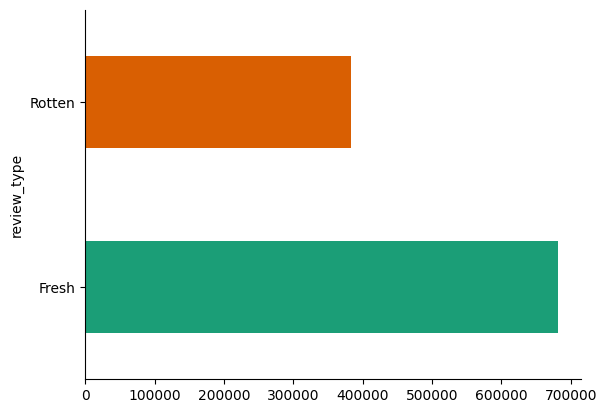

In [ ]:
from matplotlib import pyplot as plt
import seaborn as sns
dataCleaned.groupby('review_type').size().plot(kind='barh', color=sns.palettes.mpl_palette('Dark2'))
plt.gca().spines[['top', 'right',]].set_visible(False)
dataCleaned['review_type'].value_counts()

In [ ]:
df = dataCleaned

# Display the DataFrame
print(df.head)
df.describe()


<bound method NDFrame.head of         review_type                                     review_content
0             Fresh  A fantasy adventure that fuses Greek mythology...
1             Fresh  Uma Thurman as Medusa, the gorgon with a coiff...
2             Fresh  With a top-notch cast and dazzling special eff...
3             Fresh  Whether audiences will get behind The Lightnin...
4            Rotten  What's really lacking in The Lightning Thief i...
...             ...                                                ...
1130008       Fresh  A rousing reconstruction of the 1879 Battle of...
1130013       Fresh  Seen today, it's not only a startling indictme...
1130014       Fresh  A rousing visual spectacle that's a prequel of...
1130015      Rotten  A simple two-act story: Prelude to war, and th...
1130016      Rotten  Rides the line between being a pure artifact o...

[1064211 rows x 2 columns]>


,review_type,review_content
count,1064211,1064211
unique,2,949181
top,Fresh,Parental Content Review
freq,681035,267


In [53]:
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(df['review_content'], df['review_type'], test_size = 0.2, random_state = 0)
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size = 0.125, random_state = 0)

# fine tuning

In [ ]:
from transformers import Trainer
from transformers import AutoTokenizer
from transformers import AutoModelForSequenceClassification
from transformers import TrainingArguments
import pandas as pd

# Load the tokenizer and model
model_name = 'mrm8488/camembert-base-finetuned-movie-review-sentiment-analysis'
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=2)


In [55]:
from torch.utils.data import Dataset

class SentimentDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_length=128):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_length = max_length

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = self.texts[idx]
        label = self.labels[idx]
        encoding = self.tokenizer(
            text,
            max_length=self.max_length,
            padding='max_length',
            truncation=True,
            return_tensors='pt'
        )
        item = {key: val.squeeze() for key, val in encoding.items()}
        item['labels'] = torch.tensor(label, dtype=torch.long)
        return item

# Map labels to the range [0, num_labels-1]
label_mapping = {'Rotten': 0, 'Fresh': 1}
y_train = y_train.map(label_mapping).tolist()
y_val = y_val.map(label_mapping).tolist()
y_test = y_test.map(label_mapping).tolist()

train_dataset = SentimentDataset(x_train.tolist(), y_train, tokenizer)
val_dataset = SentimentDataset(x_val.tolist(), y_val, tokenizer)
test_dataset = SentimentDataset(x_test.tolist(), y_test, tokenizer)


In [56]:
import torch
import numpy as np
from transformers import TrainingArguments, Trainer
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report


def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=1)
    acc = accuracy_score(labels, predictions)
    return {'accuracy': acc}

# Training arguments
training_args = TrainingArguments(
    output_dir='./results',         # Directory to save the final model
    num_train_epochs=2,             # Number of training epochs
    per_device_train_batch_size=40, # Batch size for training
    per_device_eval_batch_size=40,  # Batch size for evaluation
    warmup_steps=500,               # Number of warmup steps for learning rate scheduler
    weight_decay=0.01,              # Strength of weight decay
    logging_dir='./logs',           # Directory to save logs
    logging_steps=10,               # Log every 10 steps
    eval_strategy="epoch",          # Evaluate the model at the end of each epoch
    save_strategy="epoch",          # Save checkpoint at the end of each epoch
    save_total_limit=1,             # Limit the total number of checkpoints saved. Only the last 1 will be kept.
    load_best_model_at_end=True,    # Load the best model when finished training (according to the validation loss)
    metric_for_best_model="accuracy" # Specify the evaluation metric to use for comparing checkpoints
)

# Initialize Trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,  # Optionally, you can add a validation dataset
    compute_metrics=compute_metrics  # Add the custom metrics function
)

# Train the model
trainer.train()


Epoch,Training Loss,Validation Loss,Accuracy
1,0.294100,0.324107,0.866220


Epoch,Training Loss,Validation Loss,Accuracy
1,0.294100,0.324107,0.866220
2,0.239900,0.312331,0.876674


TrainOutput(global_step=9366, training_loss=0.3072378573167179, metrics={'train_runtime': 7719.8716, 'train_samples_per_second': 48.524, 'train_steps_per_second': 1.213, 'total_flos': 2.4640350334464e+16, 'train_loss': 0.3072378573167179, 'epoch': 2.0})

In [59]:
# Predict on test data
predictions = trainer.predict(test_dataset)
predicted_labels = np.argmax(predictions.predictions, axis=1)
accuracy = (predicted_labels == y_test).mean()
print("Test Accuracy:", accuracy)

Test Accuracy: 0.8732645822077099


In [60]:
from sklearn.metrics import confusion_matrix, classification_report

# Compute confusion matrix
cm = confusion_matrix(y_test, predicted_labels)
print("Confusion Matrix:")
print(cm)

# Compute classification report
report = classification_report(y_test, predicted_labels)
print("Classification Report:")
print(report)

# Compute accuracy
accuracy = (predicted_labels == y_test).mean()
print("Test Accuracy:", accuracy)

Confusion Matrix:
[[12357  2843]
 [ 2552 24817]]
Classification Report:
              precision    recall  f1-score   support

           0       0.83      0.81      0.82     15200
           1       0.90      0.91      0.90     27369

    accuracy                           0.87     42569
   macro avg       0.86      0.86      0.86     42569
weighted avg       0.87      0.87      0.87     42569

Test Accuracy: 0.8732645822077099


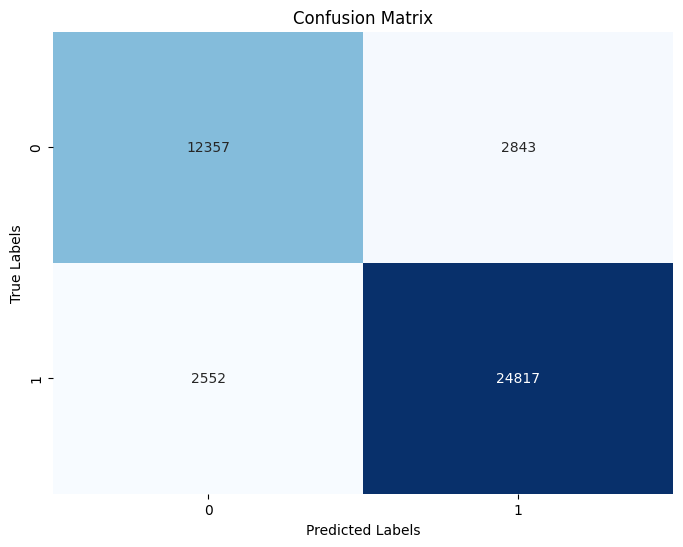

In [61]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix


# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False)
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.title("Confusion Matrix")
plt.show()


In [57]:
# Save the trained model
model.save_pretrained("./camembert_trained_model")


In [58]:
import pickle

# Save the model as a pickle file
with open('camembert_trained_model.pkl', 'wb') as f:
    pickle.dump(model, f)
